In [13]:
import sys
sys.path.append('../')

# from qiskit_ibm_runtime import QiskitRuntimeService
from investigation_functions import circuit_funcs, data_extract_funcs
# import config

from investigation_functions import  sim_function
import config
# import backend_vars

from qiskit_ibm_runtime.fake_provider import  FakeTorino, FakeBrisbane
from qiskit_ibm_runtime.fake_provider import FakeFez, FakeMarrakesh

from qiskit import transpile

from csv import DictWriter
import pandas as pd


In [5]:

nr_qubits = 4
qc_set = circuit_funcs.make_set_of_3(nr_qubits)

In [ ]:
sim_backend = FakeBrisbane()
    # Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuits = transpile(qc_set, backend =sim_backend, optimization_level =0)

In [25]:
print(transpiled_circuits[2].depth())
print(transpiled_circuits[2].width())
print(transpiled_circuits[2].size())
print(transpiled_circuits[2].count_ops())

115
131
226
OrderedDict({'rz': 130, 'sx': 74, 'ecr': 18, 'measure': 4, 'barrier': 1})


In [38]:
def save_transpiled_metrics(nr_qubits,fake_backends,file_name,dirr):
    qc_set = circuit_funcs.make_set_of_3(nr_qubits)
    for backend in fake_backends:
        # print(backend.name)
        transpiled_circuits = transpile(qc_set, backend =backend, optimization_level =0)
        for circ in range(3):
            # print("circ:"+str(circ))
            depth = transpiled_circuits[circ].depth()
            size = transpiled_circuits[circ].size()
            width = transpiled_circuits[circ].width()
            n_ops = transpiled_circuits[circ].count_ops()
            row = {
                'nr_qubits': nr_qubits,
                'backend': backend.name,
                'circuit': circ+1,
                'depth': depth,
                'size': size,
                'width': width,
                # 'n_ops': n_ops
            } | n_ops
            fields = ['nr_qubits','backend','circuit','depth','size',
                      'width','rz','ecr', 'barrier', 'x', 'measure',
                        'sx','cz']
            
            with open(dirr+file_name, 'a', newline='') as f:
                writer = DictWriter(f, fieldnames=fields)
                writer.writerow(row)

def create_transpiled_metrics_csv(file_name,dirr):
    fields = ['nr_qubits','backend','circuit','depth','size','width',
              'rz','ecr', 'barrier', 'x', 'measure', 'sx','cz']
    with open(dirr+file_name, 'w', newline='') as f:
        writer = DictWriter(f, fieldnames=fields)
        writer.writeheader()

In [56]:
fake_backends = [FakeBrisbane(), FakeTorino(), FakeFez(), FakeMarrakesh()]
dirr = '../Transpiled_circuits/'
file_name = 'transpiled_metrics_4qubits.csv'

In [ ]:
# for nq in [4]:
#     create_transpiled_metrics_csv(file_name,dirr)
#     save_transpiled_metrics(nq,fake_backends,file_name,dirr)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\epste\anaconda3\envs\qiskE\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\epste\anaconda3\envs\qiskE\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\epste\anaconda3\envs\qiskE\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\epste\anaconda3\envs\qiskE\Lib\site-packages\qiskit\providers\__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (c:\Users\epste\anaconda3\envs\qiskE\Lib\site-packages\qiskit\providers\__init__.p

In [58]:
df_4q = pd.read_csv('../Transpiled_circuits/transpiled_metrics_4qubits.csv')
df_8q = pd.read_csv('../Transpiled_circuits/transpiled_metrics_8qubits.csv')
df_16q = pd.read_csv('../Transpiled_circuits/transpiled_metrics_16qubits.csv')

df_all = pd.concat([df_4q,df_8q,df_16q])

In [59]:
df_allm = df_all.melt(id_vars=['nr_qubits','backend','circuit'], 
                      value_vars=['depth','size','rz','ecr', 'barrier', 'x', 'measure',
                                  'sx','cz'],
                      var_name ='metrics',
                      value_name='vals')

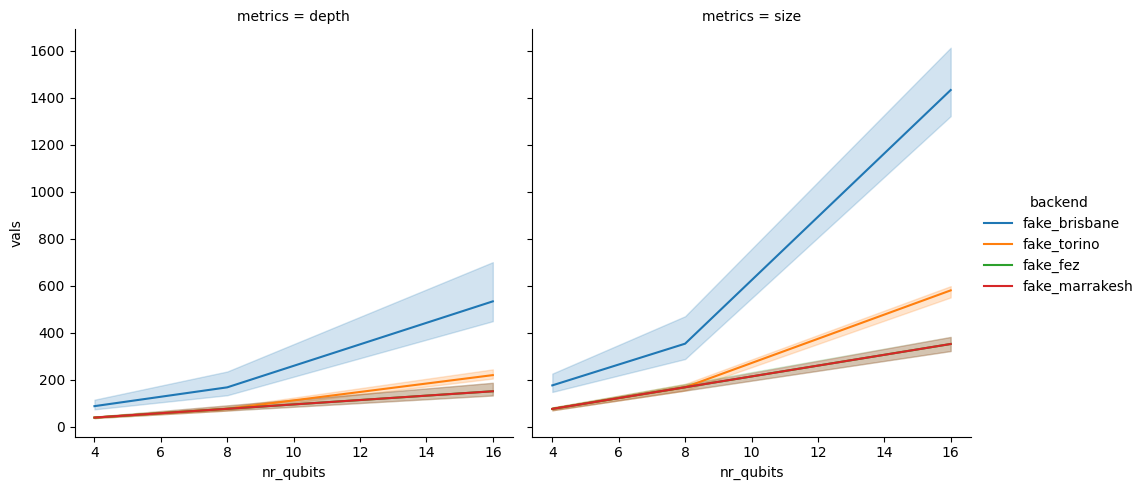

In [60]:
import seaborn as sns

sns.relplot(
    data=df_allm[df_allm['metrics'].isin(['depth','size'])],
    x='nr_qubits', 
    y='vals', 
    hue='backend', 
    col = 'metrics',
    kind='line'
)

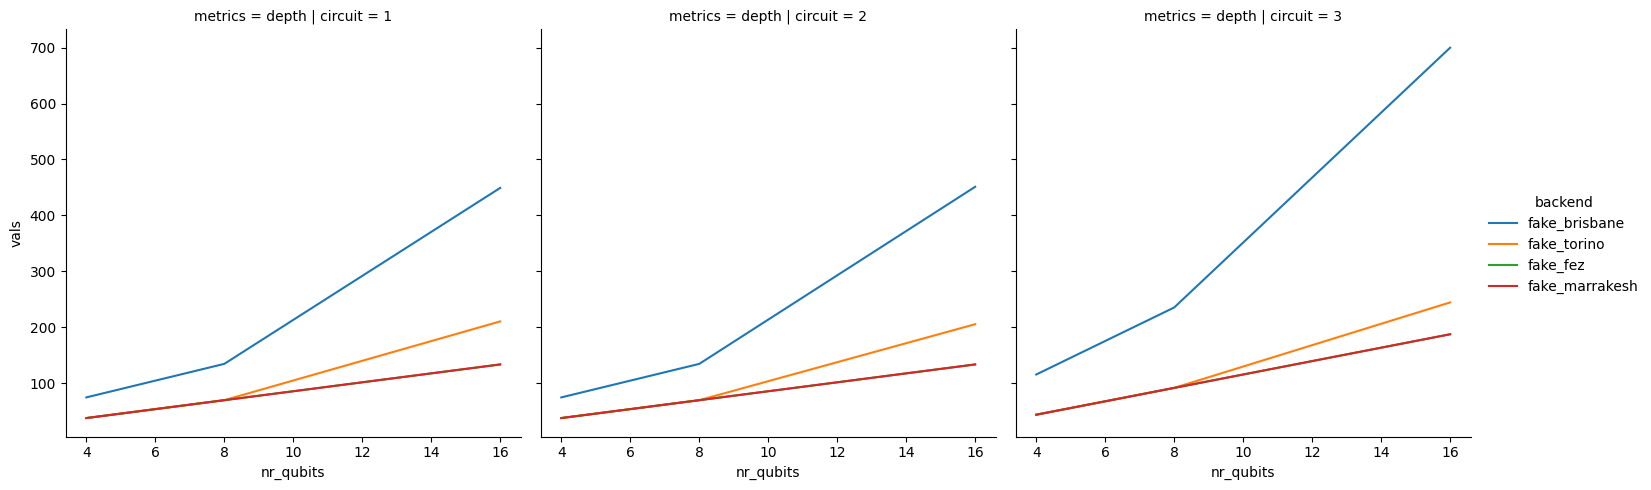

In [62]:
sns.relplot(
    data=df_allm[df_allm['metrics'].isin(['depth'])],
    x='nr_qubits', 
    y='vals', 
    hue='backend', 
    row = 'metrics',
    col = 'circuit',
    kind='line'
)

<Axes: xlabel='nr_qubits', ylabel='vals'>

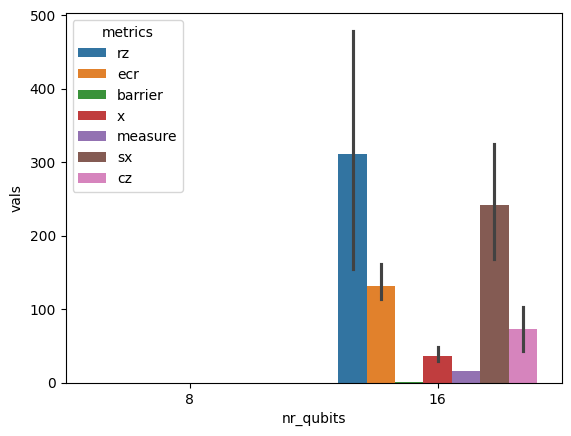

In [54]:
sns.barplot(
    data=df_allm[~df_allm['metrics'].isin(['depth','size'])],
    x='nr_qubits', 
    y='vals', 
    # style='backend', 
    hue = 'metrics'
    # col_wrap = 3
)